### Задание 1
Используем файл keywords.csv.
Необходимо написать гео-классификатор, который каждой строке сможет выставить географическую принадлежность определенному региону. Т. е. если поисковый запрос содержит название города региона, то в столбце 'region' пишется название этого региона. Если поисковый запрос не содержит названия города, то ставим 'undefined'.

In [173]:
# Правила распределения по регионам Центр, Северо-Запад и Дальний Восток:
geo_data = {
    'Центр': ['москва', 'тула', 'ярославль'],
    'Северо-Запад': ['петербург', 'псков', 'мурманск'],
    'Дальний Восток': ['владивосток', 'сахалин', 'хабаровск']
}
# Результат классификации запишите в отдельный столбец region.

In [174]:
import pandas as pd
keywords = pd.read_csv('keywords.csv')

In [175]:
# Пишем функцию, которая принимает запрос и словарь. Дробит запрос по словам
# Ищет слова в словаре по значениям и возвращает ключи
def geo_region(row, regions):    
    # Если строка из одного слова - ищем слово
    if row['keyword'].count(' ') == 0:
        word = row['keyword']
        for key, value in regions.items():
            if word in value:
                return key
    # Если строка из нескольких слов - перебираем слова
    else:
        keyword = row['keyword'].split(' ')
        for word in keyword:
            for key, value in regions.items():
                if word in value:
                    return key
    return 'undefined'

In [176]:
# Применяем функцию к датафрейму и проверяем результат
keywords['region'] = keywords.apply(geo_region, regions=geo_data, axis=1)
keywords[keywords['region'] != 'undefined'].sort_values(by = 'keyword').head()

,keyword,shows,region
3275,100 сп владивосток,76418,Дальний Восток
9293,100 сп хабаровск,29475,Дальний Восток
26305,100сп владивосток,12172,Дальний Восток
20332,100сп владивосток совместные покупки,18197,Дальний Восток
99084,122 медсанчасть санкт петербург официальный сайт,3679,Северо-Запад


### Задание 2
Напишите функцию, которая классифицирует фильмы из материалов занятия по следующим правилам:
    - оценка 2 и меньше - низкий рейтинг
    - оценка 4 и меньше - средний рейтинг
    - оценка 4.5 и 5 - высокий рейтинг

Результат классификации запишите в столбец class

In [191]:
ratings = pd.read_csv('ratings.csv')

In [192]:
def rating_class(row):
    if row['rating'] <= 2.0:
        return 'низкий рейтинг'
    elif row['rating'] <= 4.0:
        return 'средний рейтинг'
    elif row['rating'] > 4.0:
        return 'высокий рейтинг'
    else:
        return 'ошибка'

In [195]:
ratings['class'] = ratings.apply(rating_class, axis = 1)
ratings.head()

,userId,movieId,rating,timestamp,class
0,1,31,2.5,1260759144,средний рейтинг
1,1,1029,3.0,1260759179,средний рейтинг
2,1,1061,3.0,1260759182,средний рейтинг
3,1,1129,2.0,1260759185,низкий рейтинг
4,1,1172,4.0,1260759205,средний рейтинг


### Задание 3
Посчитайте среднее значение Lifetime киноманов (пользователи, которые поставили 100 и более рейтингов). Под Lifetime понимается разница между максимальным и минимальным значением timestamp для каждого пользователя. Ответ дайте в днях.

In [243]:
ratings = pd.read_csv('ratings.csv')

In [244]:
# Первым делом выбираем киноманов в список
agr_temp = ratings.groupby('userId').count()
fans = agr_temp[agr_temp['rating'] >= 100].reset_index()['userId'].tolist()

In [245]:
# Оставляем в датафрейме только фанатов
ratings = ratings[ratings['userId'].isin(fans)]

In [246]:
# Считаем минимальную и максимальную дату оценки для каждого киномана. Записываем в датафрейм
ratings = ratings.groupby('userId').agg(['min', 'max'])['timestamp']

In [247]:
# Пишем функцию считающую дни между min и max
def lifetime(row):
    return round((row['max'] - row['min']) / 60 / 60 / 24, 0)

In [248]:
# Применяем функцию на датафрейм и проверяем рузультат
ratings['lifetime'] = ratings.apply(lifetime, axis = 1)
ratings.head()

,min,max,lifetime
userId,,,
4,949778714,949982274,2.0
5,1163373044,1163375145,0.0
8,1154389340,1154474527,1.0
15,997937239,1469330735,5456.0
17,1127468587,1127476640,0.0


### Задание 4
Есть мнение, что "раньше снимали настоящее кино, не то что сейчас". Ваша задача проверить это утверждение, используя файлы с рейтингами фильмов из материалов занятия. Т. е. проверить верно ли, что с ростом года выпуска фильма его средний рейтинг становится ниже.

При этом мы не будем затрагивать субьективные факторы выставления этих рейтингов, а пройдемся по следующему алгоритму:

1. В переменную years запишите список из всех годов с 1950 по 2010.
2. Напишите функцию production_year, которая каждой строке из названия фильма выставляет год выпуска. Не все названия фильмов содержат год выпуска в одинаковом формате, поэтому используйте следующий алгоритм:
    - для каждой строки пройдите по всем годам списка years
    - если номер года присутствует в названии фильма, то функция возвращает этот год как год выпуска
    - если ни один из номеров года списка years не встретился в названии фильма, то возвращается 1900 год
3. Запишите год выпуска фильма по алгоритму пункта 2 в новый столбец 'year'
4. Посчитайте средний рейтинг всех фильмов для каждого значения столбца 'year' и отсортируйте результат по убыванию рейтинга

In [30]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [31]:
# Выполняем задачи 1 и 2
years = [x for x in range(1950, 2011)]
def production_year(row, years):
    for year in years:
        if str(year) in row['title']:
            return year
    return 1900    

In [32]:
# Задача 3
movies['year'] = movies.apply(production_year, years = years, axis = 1)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [33]:
# Задача 4
ratings = ratings.merge(movies, on = 'movieId', how = 'left')

In [71]:
data = ratings.groupby(by = 'year').mean().reset_index().sort_values('rating', ascending = False)
data.head()

,year,userId,movieId,rating,timestamp
8,1957,360.933544,2750.965190,4.014241,1.083707e+09
23,1972,359.694878,3983.538976,4.011136,1.122759e+09
3,1952,346.394737,4107.796053,4.000000,1.090512e+09
5,1954,358.228324,2867.661850,3.994220,1.070591e+09
2,1951,347.106996,2605.588477,3.983539,1.052714e+09


In [100]:
# В качестве бонуса, попробуем оценить статистическую значимость такого утверждения
# Для начала нужно понять что значит "Раньше"
# Буду считать, что для моих ровесников это до 2000 года
data['when'] = data.apply(lambda x: 'later' if x['year'] < 2000 else 'now', axis = 1)

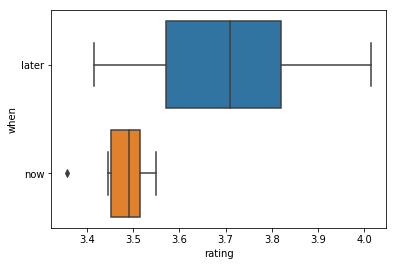

In [104]:
import seaborn as sns
sns.boxplot(x = data['rating'], y = data['when'])
# Как видим, среднее значение рейтингов "сейчас" не попадает в доверительный интервал "раньше"
# А еще оценки "сейчас" распределены подозрительно плотнее